# Evaluate and predict customer churn

This notebook is an adaptation from the work done by [Sidney Phoon and Eleva Lowery](https://github.com/IBMDataScience/DSX-DemoCenter/tree/master/DSX-Local-Telco-Churn-master) with the following modifications:

* Use datasets persisted in DB2 Warehouse running on ICP
* Deploy and run the notebook on DSX local running on IBM Cloud Private (ICP)
* Run spark Machine learning job on ICP as part of the worker nodes.
* Document some actions for a beginner data scientist / developer who wants to understand what's going on.

The goal is to demonstrate how to build a predictive model with Spark machine learning API (SparkML) to predict customer churn, and deploy it for scoring in Machine Learning (ML) running on ICP. There is an equivalent notebook to run on Watson Data Platform and Watson Machine Learning.


## Scope

A lot of industries have the issue of customers moving to competitors when the product differentiation is not that important, or there is some customer support issues. One industry illustrating this problem is the telecom industry with mobile, internet and IP TV product offerings.

## Note book explanations

The notebook aims to follow the classical data science modeling steps:

load the data
prepare the data
analyze the data (iterate on those two activities)
build a model
validate the accuracy of the model
deploy the model
consume the model as a service

This jupyter notebook uses Apache Spark to run the machine learning jobs to build decision trees using random forest classifier to assess when a customer is at risk to move to competitor. Apache Spark offers a Python module called pyspark to operate on data and use ML constructs.

### Start by all imports
As a best practices for notebook implementation is to do the import at the top of the notebook. 
* [Spark SQLContext](https://spark.apache.org/docs/latest/sql-programming-guide.html) a spark module to process structured data
* [spark conf]() to access Spark cluster configuration and then be able to execute queries
* [pandas](https://pandas.pydata.org) Python super library for data analysis
* [brunel](https://github.com/Brunel-Visualization/Brunel/wiki) API and tool to visualize data quickly. 
* [pixiedust](www.ibm.com/PixieDust) Visualize data inside Jupyter notebooks

The first cell below is to execute some system commands to update the kernel with updated dependant library.

In [2]:
# Library required for pixiedust - a visualization and dashboarding framework
!pip install --user --upgrade pixiedust

Requirement already up-to-date: pixiedust in /user-home/1002/.local/lib/python2.7/site-packages
Requirement already up-to-date: astunparse in /user-home/1002/.local/lib/python2.7/site-packages (from pixiedust)
Requirement already up-to-date: mpld3 in /opt/conda/lib/python2.7/site-packages (from pixiedust)
Requirement already up-to-date: markdown in /user-home/1002/.local/lib/python2.7/site-packages (from pixiedust)
Requirement already up-to-date: geojson in /user-home/1002/.local/lib/python2.7/site-packages (from pixiedust)
Requirement already up-to-date: lxml in /user-home/1002/.local/lib/python2.7/site-packages (from pixiedust)
Requirement already up-to-date: six<2.0,>=1.6.1 in /user-home/1002/.local/lib/python2.7/site-packages (from astunparse->pixiedust)
Requirement already up-to-date: wheel<1.0,>=0.23.0 in /user-home/1002/.local/lib/python2.7/site-packages (from astunparse->pixiedust)


In [3]:
import pyspark
import pandas as pd
import brunel
import numpy as np
from pyspark.sql import SQLContext
from pyspark.conf import SparkConf
from pyspark.sql import SparkSession
from pyspark.sql.types import DoubleType
from pyspark.sql.types import DecimalType
from pyspark.sql.types import IntegerType
from pyspark.sql.types import LongType
from pyspark.ml.feature import OneHotEncoder, StringIndexer, VectorIndexer, IndexToString
from pyspark.ml import Pipeline
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pixiedust.display import *


Pixiedust database opened successfully


## Load data from DB2

DSX ICP can be used to bring in data from multiple sources including but not limited to, files, datastores on cloud as well as on premises. DSX ICP includes features to connect to data sources, bring in the data, refine, and then perform analytics.

In this sample we connect to DB2 Data Warehouse deployed on ICP and bring data about customer, call notes and marketing campaign in.

In [4]:
import dsx_core_utils

dataSet = dsx_core_utils.get_remote_data_set_info('CUSTOMER')
dataSource = dsx_core_utils.get_data_source_info(dataSet['datasource'])
print(dataSource)
dbTableOrQuery = dataSet['schema'] + '.' + dataSet['table']
print(dbTableOrQuery)
sparkSession = SparkSession(sc).builder.getOrCreate()
df_customer_transactions = sparkSession.read.format("jdbc").option("url", dataSource['URL']).option("dbtable",dbTableOrQuery).option("user",'BLUADMIN').option("password","changemeplease").load()
df_customer_transactions.show(5)
df_customer_transactions.printSchema()


{u'description': u'', u'URL': u'jdbc:db2://172.16.40.131:32166/BLUDB', 'driver_class': 'com.ibm.db2.jcc.DB2Driver', u'dsx_artifact_type': u'datasource', u'shared': True, u'type': u'DB2', u'name': u'CUSTOMER'}
BLUADMIN.CUSTOMER
+----+------+------+--------+----------+---------+---------+--------------+-------+------------+-------------+-----+-------+---------+-------------+--------------------+------+--------+-----------+-----+
|  ID|GENDER|STATUS|CHILDREN|EST_INCOME|CAR_OWNER|      AGE|MARITAL_STATUS|ZIPCODE|LONGDISTANCE|INTERNATIONAL|LOCAL|DROPPED|PAYMETHOD|LOCALBILLTYPE|LONGDISTANCEBILLTYPE| USAGE|RATEPLAN|DEVICEOWNED|CHURN|
+----+------+------+--------+----------+---------+---------+--------------+-------+------------+-------------+-----+-------+---------+-------------+--------------------+------+--------+-----------+-----+
|1311|     F|     M|       0|  53432.20|        Y|57.000000|       Married|   null|       12.56|            0|83.48|      0|       CH|    FreeLocal|            S

In [5]:
dataSet = dsx_core_utils.get_remote_data_set_info('CALLNOTES')
dataSource = dsx_core_utils.get_data_source_info(dataSet['datasource'])
print(dataSource)
dbTableOrQuery = dataSet['schema'] + '.' + dataSet['table']
print(dbTableOrQuery)
sparkSession = SparkSession(sc).builder.getOrCreate()
df_call_notes = sparkSession.read.format("jdbc").option("url", dataSource['URL']).option("dbtable",dbTableOrQuery).option("user",'BLUADMIN').option("password","changemeplease").load()
df_call_notes.show(5)
df_call_notes.printSchema()


{u'description': u'', u'URL': u'jdbc:db2://172.16.40.131:32166/BLUDB', 'driver_class': 'com.ibm.db2.jcc.DB2Driver', u'dsx_artifact_type': u'datasource', u'shared': True, u'type': u'DB2', u'name': u'CUSTOMER'}
BLUADMIN.CALLNOTES
+----+--------------------+----------+--------------+--------+
|  ID|            COMMENTS|SENTIMENTS|      KEYWORD1|KEYWORD2|
+----+--------------------+----------+--------------+--------+
|2253|Wants to change a...|      null|update records| address|
|2254|Wants to change a...|      null|update records| address|
|2255|Wants to change a...|      null|update records| address|
|2256|Wants to change a...|      null|update records| address|
|2257|Needed help figur...|analytical|       billing| charges|
+----+--------------------+----------+--------------+--------+
only showing top 5 rows

root
 |-- ID: integer (nullable = true)
 |-- COMMENTS: string (nullable = true)
 |-- SENTIMENTS: string (nullable = true)
 |-- KEYWORD1: string (nullable = true)
 |-- KEYWORD2: str

In [6]:
dataSet = dsx_core_utils.get_remote_data_set_info('CAMPAIGNRESPONSES_EXPANDED')
dataSource = dsx_core_utils.get_data_source_info(dataSet['datasource'])
print(dataSource)
dbTableOrQuery = dataSet['schema'] + '.' + dataSet['table']
print(dbTableOrQuery)
sparkSession = SparkSession(sc).builder.getOrCreate()
df_campaign_responses = sparkSession.read.format("jdbc").option("url", dataSource['URL']).option("dbtable",dbTableOrQuery).option("user",'BLUADMIN').option("password","changemeplease").load()
df_campaign_responses.show(5)
df_campaign_responses.printSchema()

{u'description': u'', u'URL': u'jdbc:db2://172.16.40.131:32166/BLUDB', 'driver_class': 'com.ibm.db2.jcc.DB2Driver', u'dsx_artifact_type': u'datasource', u'shared': True, u'type': u'DB2', u'name': u'CUSTOMER'}
BLUADMIN.CAMPAIGNRESPONSES_EXPANDED
+----+------------------+---------------------------+-------------------------------------+
|  ID|RESPONDED_CAMPAIGN|OWNS_MULTIPLE_PHONE_NUMBERS|AVERAGE_TEXT_MESSAGES__90_DAY_PERIOD_|
+----+------------------+---------------------------+-------------------------------------+
|3064|       Kids Tablet|                          Y|                                 1561|
|3077|       Kids Tablet|                          Y|                                 1225|
|3105|       Kids Tablet|                          Y|                                 1661|
|3106|       Kids Tablet|                          N|                                 2498|
|3108|       Kids Tablet|                          N|                                 1118|
+----+-------------

## Data Preparation
The next few steps involve a series of data preparation tasks such as filling the missing values, joining datasets etc. The following cell fills the null values for average SMS count and replaces Nulls with spaces for other fields. 

In [7]:
df_campaign_responses = df_campaign_responses.na.fill({'AVERAGE_TEXT_MESSAGES__90_DAY_PERIOD_':'0'})
df_call_notes = df_call_notes.na.fill({'SENTIMENTS':' '})
df_call_notes = df_call_notes.na.fill({'KEYWORD1':' '})
df_call_notes = df_call_notes.na.fill({'KEYWORD2':' '})

In the following cell we join some of the customer and call note data sources using the ID field. This ID field is the one coming from the CUSTOMER DB2 transactional database.

In [8]:
data_joined_callnotes_churn = df_call_notes.join(df_customer_transactions,df_call_notes['ID']==df_customer_transactions['ID'],'inner').select(df_call_notes['SENTIMENTS'],df_call_notes['KEYWORD1'],df_call_notes['KEYWORD2'],df_customer_transactions['*'])
data_joined_callnotes_churn_campaign = df_campaign_responses.join(data_joined_callnotes_churn,df_campaign_responses['ID']==data_joined_callnotes_churn['ID'],'inner').select(data_joined_callnotes_churn['*'],df_campaign_responses['RESPONDED_CAMPAIGN'],df_campaign_responses['OWNS_MULTIPLE_PHONE_NUMBERS'],df_campaign_responses['AVERAGE_TEXT_MESSAGES__90_DAY_PERIOD_'])
data_joined_callnotes_churn_campaign.take(5)

[Row(SENTIMENTS=u' ', KEYWORD1=u'help', KEYWORD2=u'support', ID=148, GENDER=u'M', STATUS=u'M', CHILDREN=2, EST_INCOME=Decimal('91272.20'), CAR_OWNER=u'Y', AGE=Decimal('25.033333'), MARITAL_STATUS=u'Married', ZIPCODE=None, LONGDISTANCE=Decimal('26.99'), INTERNATIONAL=0, LOCAL=Decimal('13.01'), DROPPED=0, PAYMETHOD=u'CC', LOCALBILLTYPE=u'FreeLocal', LONGDISTANCEBILLTYPE=u'Standard', USAGE=Decimal('40.00'), RATEPLAN=3, DEVICEOWNED=u'ipho', CHURN=u'F', RESPONDED_CAMPAIGN=u'Android Phone', OWNS_MULTIPLE_PHONE_NUMBERS=u'N', AVERAGE_TEXT_MESSAGES__90_DAY_PERIOD_=1900),
 Row(SENTIMENTS=u' ', KEYWORD1=u'update records', KEYWORD2=u'address', ID=463, GENDER=u'M', STATUS=u'M', CHILDREN=0, EST_INCOME=Decimal('69168.40'), CAR_OWNER=u'Y', AGE=Decimal('62.426667'), MARITAL_STATUS=u'Married', ZIPCODE=None, LONGDISTANCE=Decimal('14.16'), INTERNATIONAL=6, LOCAL=Decimal('214.73'), DROPPED=0, PAYMETHOD=u'CC', LOCALBILLTYPE=u'Budget', LONGDISTANCEBILLTYPE=u'Standard', USAGE=Decimal('234.91'), RATEPLAN=2, DE

##### The following code block is intended to get a feel for Spark DataFrame APIs. We attempt to fix some of the column titles to promote readability, and also remove a duplicate column (Status and Marital Status are the same).  Finally convert the DataFrame to Python Pandas structure for visualization. Since some fields are string types from DB2 tables, let us change some of them to other types

In [9]:
# Change some column names

data_joined_callnotes_churn_campaign = data_joined_callnotes_churn_campaign.withColumnRenamed("SENTIMENTS", "SENTIMENT").withColumnRenamed("OWNS_MULTIPLE_PHONE_NUMBERS","OMPN")
data_joined_callnotes_churn_campaign = data_joined_callnotes_churn_campaign.withColumnRenamed("KEYWORD1", "KEYWORD_COMPONENT").withColumnRenamed("KEYWORD2","KEYWORD_QUERY")
data_joined_callnotes_churn_campaign = data_joined_callnotes_churn_campaign.withColumnRenamed("AVERAGE_TEXT_MESSAGES__90_DAY_PERIOD_", "SMSCOUNT").withColumnRenamed("CAR_OWNER","CAROWNERSHIP")
data_joined_callnotes_churn_campaign = data_joined_callnotes_churn_campaign.withColumnRenamed("MARITAL_STATUS", "MARITALSTATUS").withColumnRenamed("EST_INCOME","INCOME")
data_joined_callnotes_churn_campaign = data_joined_callnotes_churn_campaign.drop('Status')

# Change some of the data types

data_joined_callnotes_churn_campaign = data_joined_callnotes_churn_campaign.withColumn("CHILDREN", data_joined_callnotes_churn_campaign["CHILDREN"].cast(IntegerType()))
data_joined_callnotes_churn_campaign = data_joined_callnotes_churn_campaign.withColumn("INCOME", data_joined_callnotes_churn_campaign["INCOME"].cast(DecimalType()))
data_joined_callnotes_churn_campaign = data_joined_callnotes_churn_campaign.withColumn("AGE", data_joined_callnotes_churn_campaign["AGE"].cast(IntegerType()))
data_joined_callnotes_churn_campaign = data_joined_callnotes_churn_campaign.withColumn("LONGDISTANCE", data_joined_callnotes_churn_campaign["LONGDISTANCE"].cast(DecimalType()))
data_joined_callnotes_churn_campaign = data_joined_callnotes_churn_campaign.withColumn("INTERNATIONAL", data_joined_callnotes_churn_campaign["INTERNATIONAL"].cast(DecimalType()))
data_joined_callnotes_churn_campaign = data_joined_callnotes_churn_campaign.withColumn("LOCAL", data_joined_callnotes_churn_campaign["LOCAL"].cast(DecimalType()))
data_joined_callnotes_churn_campaign = data_joined_callnotes_churn_campaign.withColumn("DROPPED", data_joined_callnotes_churn_campaign["DROPPED"].cast(IntegerType()))
data_joined_callnotes_churn_campaign = data_joined_callnotes_churn_campaign.withColumn("USAGE", data_joined_callnotes_churn_campaign["USAGE"].cast(DecimalType()))
data_joined_callnotes_churn_campaign = data_joined_callnotes_churn_campaign.withColumn("RATEPLAN", data_joined_callnotes_churn_campaign["RATEPLAN"].cast(IntegerType()))
data_joined_callnotes_churn_campaign = data_joined_callnotes_churn_campaign.withColumn("SMSCOUNT", data_joined_callnotes_churn_campaign["SMSCOUNT"].cast(IntegerType()))
data_joined_callnotes_churn_campaign.show(10)
data_joined_callnotes_churn_campaign.printSchema()

pandas_df_callnotes_campaign_churn = data_joined_callnotes_churn_campaign.toPandas()
pandas_df_callnotes_campaign_churn.head(12)

+----------+-----------------+----------------+----+------+--------+------+------------+---+-------------+-------+------------+-------------+-----+-------+---------+-------------+--------------------+-----+--------+-----------+-----+------------------+----+--------+
| SENTIMENT|KEYWORD_COMPONENT|   KEYWORD_QUERY|  ID|GENDER|CHILDREN|INCOME|CAROWNERSHIP|AGE|MARITALSTATUS|ZIPCODE|LONGDISTANCE|INTERNATIONAL|LOCAL|DROPPED|PAYMETHOD|LOCALBILLTYPE|LONGDISTANCEBILLTYPE|USAGE|RATEPLAN|DEVICEOWNED|CHURN|RESPONDED_CAMPAIGN|OMPN|SMSCOUNT|
+----------+-----------------+----------------+----+------+--------+------+------------+---+-------------+-------+------------+-------------+-----+-------+---------+-------------+--------------------+-----+--------+-----------+-----+------------------+----+--------+
|          |             help|         support| 148|     M|       2| 91272|           Y| 25|      Married|   null|          27|            0|   13|      0|       CC|    FreeLocal|            Standard

,SENTIMENT,KEYWORD_COMPONENT,KEYWORD_QUERY,ID,GENDER,CHILDREN,INCOME,CAROWNERSHIP,AGE,MARITALSTATUS,...,PAYMETHOD,LOCALBILLTYPE,LONGDISTANCEBILLTYPE,USAGE,RATEPLAN,DEVICEOWNED,CHURN,RESPONDED_CAMPAIGN,OMPN,SMSCOUNT
0,,help,support,148,M,2,91272,Y,25,Married,...,CC,FreeLocal,Standard,40,3,ipho,F,Android Phone,N,1900
1,,update records,address,463,M,0,69168,Y,62,Married,...,CC,Budget,Standard,235,2,sam,T,Dual SIM,Y,1586
2,analytical,billing,charges,471,M,2,90104,N,34,Married,...,CC,Budget,Intnl_discount,66,3,sam,F,More Storage,N,1114
3,satisfied,battery,unpredictability,1238,F,2,3194,N,54,Married,...,CH,Budget,Standard,119,3,ipho,F,Large Display,N,1697
4,frustrated,charger,switch carrier,1342,M,0,94928,N,40,Single,...,CC,FreeLocal,Standard,94,1,ipho,T,Dual SIM,Y,1540
5,analytical,new number,customer care,1591,F,0,45613,N,14,Single,...,CC,Budget,Standard,324,4,ipho,F,Android Phone,N,1681
6,frustrated,call forwarding,features,1645,M,1,92648,N,56,Single,...,CC,Budget,Standard,32,4,ipho,T,Android Phone,N,2291
7,analytical,tablet,new offering,1959,F,1,13829,N,19,Married,...,CC,FreeLocal,Standard,177,2,ipho,T,Android Phone,N,1821
8,analytical,rate plan,customer care,1959,F,1,13829,N,19,Married,...,CC,FreeLocal,Standard,177,2,ipho,T,Android Phone,N,1821
9,,new number,service,2122,M,2,49911,Y,51,Married,...,CC,Budget,Standard,51,1,ipho,F,Android Phone,N,1487


##### The following brunel based visualization can also be performed from Data Refinery. Shown here to get the feel for APIs

In [10]:
%brunel data('pandas_df_callnotes_campaign_churn') bar y(#count) stack polar color(Sentiment) sort(#count) label(Sentiment, ' (', #count, '%)') tooltip(#all) percent(#count) legends(none)

<IPython.core.display.Javascript object>

In [11]:
%brunel data('pandas_df_callnotes_campaign_churn') bar x(Sentiment) y(#count) sort(#count) tooltip(#all)

<IPython.core.display.Javascript object>

In [12]:
%brunel data('pandas_df_callnotes_campaign_churn') treemap x(Keyword_Component) color(Keyword_Component) size(#count) label(Keyword_Query) tooltip(#all)

<IPython.core.display.Javascript object>

##### The following cell shows an example of how pixiedust can be used to build interactive dashboards, and how it can be exported out


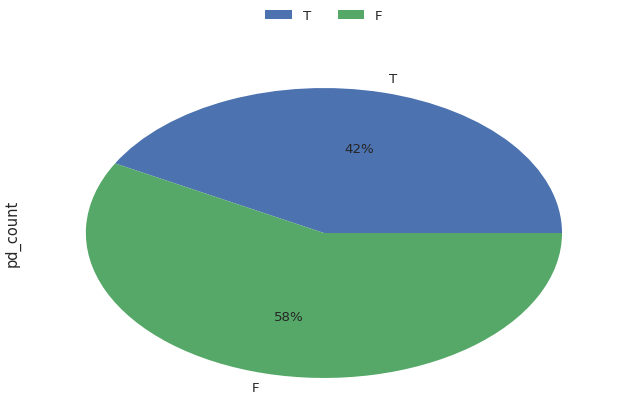

In [ ]:
#display(pandas_df_callnotes_campaign_churn)
display(data_joined_callnotes_churn_campaign)

##### Building RandomForest based classifier

In [14]:
si_gender = StringIndexer(inputCol='GENDER', outputCol='GenderIndexed',handleInvalid='error')
si_status = StringIndexer(inputCol='MARITALSTATUS',outputCol='MaritalStatusIndexed',handleInvalid='error')
si_carownership = StringIndexer(inputCol='CAROWNERSHIP',outputCol='CarOwnershipIndexed',handleInvalid='error')
#si_paymentmode = StringIndexer(inputCol='Paymethod',outputCol='PaymethodIndexed',handleInvalid='error')
si_localbill = StringIndexer(inputCol='LOCALBILLTYPE',outputCol='LocalBilltypeIndexed',handleInvalid='error')
si_longdistancebill = StringIndexer(inputCol='LONGDISTANCEBILLTYPE',outputCol='LongDistanceBilltypeIndexed',handleInvalid='error')
si_sentiment = StringIndexer(inputCol='SENTIMENT',outputCol='SentimentIndexed',handleInvalid='error')
si_multiplelines = StringIndexer(inputCol='OMPN',outputCol='OMPNIndexed',handleInvalid='error')
si_churnLabel = StringIndexer(inputCol='CHURN', outputCol='label',handleInvalid='error')
churnLabelIndexer = si_churnLabel.fit(data_joined_callnotes_churn_campaign)

#Apply OneHotEncoder so categorical features aren't given numeric importance
ohe_gender = OneHotEncoder(inputCol="GenderIndexed", outputCol="GenderIndexed"+"classVec")
ohe_maritalstatus = OneHotEncoder(inputCol="MaritalStatusIndexed", outputCol="MaritalStatusIndexed"+"classVec")
ohe_carownership = OneHotEncoder(inputCol="CarOwnershipIndexed", outputCol="CarOwnershipIndexed"+"classVec")
#ohe_paymentmode = OneHotEncoder(inputCol="PaymethodIndexed", outputCol="PaymethodIndexed"+"classVec")
ohe_localbill = OneHotEncoder(inputCol="LocalBilltypeIndexed", outputCol="LocalBilltypeIndexed"+"classVec")
ohe_longdistance = OneHotEncoder(inputCol="LongDistanceBilltypeIndexed", outputCol="LongDistanceBilltypeIndexed"+"classVec")
ohe_sentiment = OneHotEncoder(inputCol='SentimentIndexed', outputCol='SentimentIndexed'+'classVec')
ohe_multiplelines = OneHotEncoder(inputCol='OMPNIndexed', outputCol='OMPNIndexed'+'classVec')

assembler = VectorAssembler(inputCols=["GenderIndexedclassVec", "MaritalStatusIndexedclassVec", "CarOwnershipIndexedclassVec", "LocalBilltypeIndexedclassVec", \
                                       "LongDistanceBilltypeIndexedclassVec","SentimentIndexedclassVec","OMPNIndexedclassVec","CHILDREN", "INCOME", "AGE", \
                                       "LONGDISTANCE", "INTERNATIONAL", "LOCAL", "DROPPED","SMSCOUNT"], outputCol="features")

In [15]:
randomforest_classifier=RandomForestClassifier(labelCol="label", featuresCol="features")

# Convert indexed labels back to original labels.
labelConverter = IndexToString(inputCol="prediction", outputCol="predictedLabel", labels=churnLabelIndexer.labels)

pipeline = Pipeline(stages=[si_gender,si_status,si_carownership,si_localbill,si_longdistancebill,si_sentiment,si_multiplelines,churnLabelIndexer, ohe_gender,ohe_maritalstatus,ohe_carownership,ohe_localbill,ohe_longdistance,ohe_sentiment,ohe_multiplelines, assembler, randomforest_classifier, labelConverter])

##### Split the dataset into training and test using 70:30 split ratio and build the model

In [16]:
train, test = data_joined_callnotes_churn_campaign.randomSplit([0.7,0.3], seed=7)
train.cache()
test.cache()
model = pipeline.fit(train)

##### Testing the test dataset

In [17]:
results = model.transform(test)
results=results.select(results["ID"],results["CHURN"],results["label"],results["predictedLabel"],results["prediction"],results["probability"])
results.toPandas().head(6)

,ID,CHURN,label,predictedLabel,prediction,probability
0,148,F,0.0,F,0.0,"[0.8728832555, 0.1271167445]"
1,1959,T,1.0,T,1.0,"[0.285629950796, 0.714370049204]"
2,3749,T,1.0,T,1.0,"[0.165697434112, 0.834302565888]"
3,2659,F,0.0,F,0.0,"[0.714051839779, 0.285948160221]"
4,1238,F,0.0,F,0.0,"[0.87563833506, 0.12436166494]"
5,1460,F,0.0,F,0.0,"[0.925838160212, 0.0741618397881]"


##### Model Evaluation

In [18]:
prefix_precision = 'Precision model1 = {:.2f}.'
print (prefix_precision.format(results.filter(results.label == results.prediction).count() / float(results.count())))

prefix_aoc = 'Area under ROC curve = {:.2f}.'
evaluator = BinaryClassificationEvaluator(rawPredictionCol="prediction", labelCol="label", metricName="areaUnderROC")
print (prefix_aoc.format(evaluator.evaluate(results)))

Precision model1 = 0.89.
Area under ROC curve = 0.88.


In [19]:
from repository.mlrepositoryclient import MLRepositoryClient
from repository.mlrepositoryartifact import MLRepositoryArtifact

In [20]:
service_path = 'https://internal-nginx-svc.ibm-private-cloud.svc.cluster.local:12443'
ml_repository_client = MLRepositoryClient()

In [21]:
model_artifact = MLRepositoryArtifact(model, training_data=train, name="Customer Churn Prediction - db2")

# Add author information for model
model_artifact.meta.add("authorName", "Data Scientist");

##### Save pipeline and model artifacts to Machine Learning repository:

In [22]:
saved_model = ml_repository_client.models.save(model_artifact)

In [23]:
# Print the saved model properties
print "modelType: " + saved_model.meta.prop("modelType")
print "creationTime: " + str(saved_model.meta.prop("creationTime"))
print "modelVersionHref: " + saved_model.meta.prop("modelVersionHref")
print "label: " + saved_model.meta.prop("label")

modelType: sparkml-model-2.0
creationTime: 2018-02-19 22:18:53.157000+00:00
modelVersionHref: https://internal-nginx-svc.ibm-private-cloud.svc.cluster.local:12443/v2/artifacts/models/56af74d4-93f4-41bd-8069-850a5117475d/versions/4de851a3-4d05-4957-a27f-6701418e6ce4
label: CHURN
